## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

[GeoJson](https://tools.ietf.org/html/rfc7946#section-3.1.7) is a good way to add data on top of an ipyleaflet map.

For other backgrounds than open streets, you can alter the ipyleaflet.py file to point to one of [these map providers](https://leaflet-extras.github.io/leaflet-providers/preview/)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import pylab as plt

import sys
sys.path.append('./lib')

from leaflet import *

In [3]:
data_dir = "../../Data/Weather/"
meas = 'SNOW'
from pickle import load
with open(data_dir+'%s_residuals_PCA.pickle'%meas,'rb') as file:
    Res_eig=load(file)
print Res_eig.keys()

#stations.pkl
# need to unzip stations.pkl.gz first.
with open(data_dir+'stations.pkl','rb') as file:
    Stations=load(file)
Stations.head()


['eigen-vecs', 'stations']


,latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930.0
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390.0


In [4]:
import pandas as pd
Eig=pd.DataFrame(Res_eig['eigen-vecs'].transpose())
Eig.head()

,0,1,2,3
0,-0.147630,-0.116390,-0.167602,-0.114337
1,-0.376669,-0.206496,-0.247866,-0.280700
2,-0.044121,-0.104904,-0.011305,0.012315
3,-0.073336,-0.043634,0.014798,0.048017
4,0.142116,-0.263210,0.050784,0.049097


In [5]:
Eig['station']=Res_eig['stations']
Eig=Eig.set_index('station')
print Res_eig['stations'][:5]
Eig.head()

[u'USC00045571', u'US1CAED0007', u'USC00048928', u'US1CAED0009', u'USC00045356']


,0,1,2,3
station,,,,
USC00045571,-0.147630,-0.116390,-0.167602,-0.114337
US1CAED0007,-0.376669,-0.206496,-0.247866,-0.280700
USC00048928,-0.044121,-0.104904,-0.011305,0.012315
US1CAED0009,-0.073336,-0.043634,0.014798,0.048017
USC00045356,0.142116,-0.263210,0.050784,0.049097


In [6]:
table=Eig.join(Stations,how='left')

In [7]:
#table=table[['name','latitude','longitude','elevation',0,1,2,3,4,5,6,7]]
# got error, 4, 5, 6, 7 are not in index.
table=table[['name','latitude','longitude','elevation',0,1,2,3]]
table.head(4)

,name,latitude,longitude,elevation,0,1,2,3
station,,,,,,,,
USC00045571,MEYERS 4 SW,38.8167,-120.0167,1973.0,-0.147630,-0.116390,-0.167602,-0.114337
US1CAED0007,FAIR PLAY 2.8 ESE,38.5925,-120.6094,1033.3,-0.376669,-0.206496,-0.247866,-0.280700
USC00048928,TIGER CREEK PH,38.4461,-120.4992,717.8,-0.044121,-0.104904,-0.011305,0.012315
US1CAED0009,TAHOMA .5 S,39.0599,-120.1292,1925.1,-0.073336,-0.043634,0.014798,0.048017


In [8]:
import pylab as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Map

In [12]:
#min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)
max_lat = table.agg('max')['latitude']
min_lat = table.agg('min')['latitude']
max_long = table.agg('max')['longitude']
min_long = table.agg('min')['longitude']
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 8
m = Map(default_tiles=TileLayer(url=unicode('http://server.arcgisonline.com/ArcGIS/rest/services/Specialty/DeLorme_World_Base_Map/MapServer/tile/{z}/{y}/{x}'), opacity=0.6), center=center, zoom=zoom)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
for index,row in table.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    for col in range(4):
        _coef=row[col]
        if np.isnan(_coef):
            continue
        r=abs(_coef)/5
        #print r
        color=colors[col]
        signs=[[+1,+1],[+1,-1],[-1,-1],[-1,+1]]
        lat_sign,long_sign=signs[col]
        triangle=[(_lat,_long),(_lat+lat_sign*r,_long),(_lat,_long+long_sign*r),(_lat,_long)]
        if _coef<0:
            poly= Polygon(locations=triangle, weight=0,
                    color=color, opacity=0, fill_opacity=0.7,
                    fill_color=color)
        else:
            poly= Polygon(locations=triangle, weight=2,
                    color=color, opacity=0.8, fill_opacity=0,
                    fill_color=color)
        m +=poly   
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

In [10]:
m_topo = Map(default_tiles=TileLayer(url=unicode('https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png'), opacity=0.6), center=center, zoom=zoom)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m_topo += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
for index,row in table.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    for col in range(4):
        _coef=row[col]
        if np.isnan(_coef):
            continue
        r=abs(_coef)/5
        #print r
        color=colors[col]
        signs=[[+1,+1],[+1,-1],[-1,-1],[-1,+1]]
        lat_sign,long_sign=signs[col]
        triangle=[(_lat,_long),(_lat+lat_sign*r,_long),(_lat,_long+long_sign*r),(_lat,_long)]
        if _coef<0:
            poly= Polygon(locations=triangle, weight=0,
                    color=color, opacity=0, fill_opacity=0.7,
                    fill_color=color)
        else:
            poly= Polygon(locations=triangle, weight=2,
                    color=color, opacity=0.8, fill_opacity=0,
                    fill_color=color)
        m_topo +=poly   
m_topo    

KeyError: 'avg(coeff_1)'

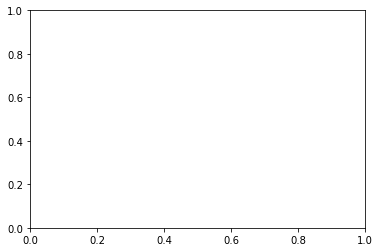

In [11]:
%matplotlib inline
table.plot.scatter(x='elevation',y='avg(coeff_1)');